In [2]:
!rm -r rice-weed-seg
!git clone https://gitlab.com/srirammandhati/rice-weed-seg.git

remote: Enumerating objects: 471, done.
remote: Counting objects: 100% (471/471), done.
remote: Compressing objects: 100% (470/470), done.
remote: Total 471 (delta 9), reused 453 (delta 0)
Receiving objects: 100% (471/471), 391.27 MiB | 4.89 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Checking out files: 100% (457/457), done.
Cloning into 'rice-weed-seg'...
remote: Enumerating objects: 471, done.
remote: Counting objects: 100% (471/471), done.
remote: Compressing objects: 100% (470/470), done.
remote: Total 471 (delta 9), reused 453 (delta 0)
Receiving objects: 100% (471/471), 391.27 MiB | 5.03 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Checking out files: 100% (457/457), done.


In [3]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 912
IMG_HEIGHT = 1024
IMG_CHANNELS = 3
TRAIN_PATH = 'rice-weed-segment/train/'
TEST_PATH = 'rice-weed-segment/test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [4]:
X = np.load("rice-weed-seg/X_all.npy")
Y_rice = np.load("rice-weed-seg/Y_rice_label.npy")
Y_all = np.load("rice-weed-seg/Y_all_label.npy")
Y_weed = np.load("rice-weed-seg/Y_weed_label.npy")

print(X.shape)
print(Y_rice.shape)
print(Y_weed.shape)
print(Y_all.shape)

(224, 1024, 912, 3)
(224, 1024, 912, 1)
(224, 1024, 912, 1)
(224, 1024, 912, 1)


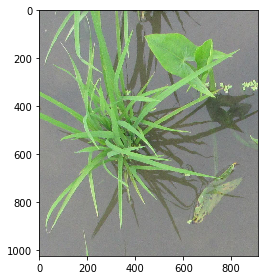

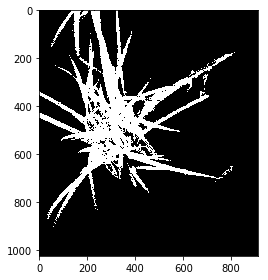

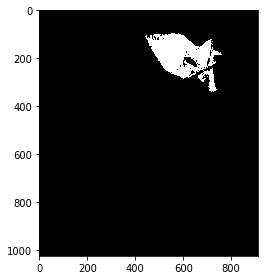

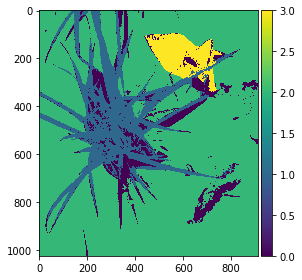

In [5]:
ix = random.randint(0, len(X))
imshow(X[ix])
plt.show()

imshow(np.squeeze(Y_rice[ix]))
plt.show()

imshow(np.squeeze(Y_weed[ix]))
plt.show()

imshow(np.squeeze(Y_all[ix]))
plt.show()

In [0]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [7]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

W0817 13:33:41.250161 139785774700416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0817 13:33:41.267811 139785774700416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0817 13:33:41.278947 139785774700416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0817 13:33:41.296530 139785774700416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0817 13:33

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1024, 912, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1024, 912, 3) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1024, 912, 16 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1024, 912, 16 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [8]:
# Fit model
csvlogger = CSVLogger("rice-weed-seg/model-for-all.log", separator=";", append=False)
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint("rice-weed-seg/model-for-all.h5", verbose=1, save_best_only=True)
results = model.fit(X[:210], Y_weed[:210], validation_split=0.2, batch_size=4, epochs=150, 
                    callbacks=[earlystopper, csvlogger, checkpointer])

Train on 168 samples, validate on 42 samples
Epoch 1/150


KeyboardInterrupt: ignored

In [9]:
# Predict on train, val and test
model = load_model('rice-weed-seg/model-for-weed.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X[:int(210*0.75)], verbose=1)
preds_val = model.predict(X[int(210*0.75):210], verbose=1)
preds_test = model.predict(X[210:], verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.3).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

ResourceExhaustedError: ignored

In [0]:
# Perform a sanity check on some random testing samples

ix = random.randint(0, len(preds_test_t))

imshow(X[210:][ix])
plt.show()


imshow(np.squeeze(Y[210:][ix]))
plt.show()

imshow(np.squeeze(preds_test_t[ix]))
plt.show()

In [10]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=3be5deec291e176aa74eb3c71407f5e90c202d2f95d1f2eb8fface9fb1800b65
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 9.9 GB  | Proc size: 3.7 GB
GPU RAM Free: 433MB | Used: 11008MB | Util  96% | Total 11441MB


In [0]:
#!kill -9 -1